In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter
from scipy.stats import norm, beta, bernoulli

In [2]:
import sys
sys.path.append("C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing")

%load_ext autoreload
%autoreload 2

In [3]:
#simple simulations
from src.simulations import SimpleSimulation
from src.simulation_melange_gaussien import GMixSimulation
from src.simulation_uniforme import UniformSimulation
#simulations with context
from src.context_generator import ContextGenerator
from src.simulation_with_context import ContextualDemandSimulation
#bandit algo
from src.binomial_bandit import BinomialBandit
from src.simple_bandit_greedy import GreedyBandit
from src.simple_bandit_ucb import UCBBandit
from src.context_bandit import ContextBandit
#evaluation algo (regret)
from src.evaluate_model import EvaluateBandit
from src.evaluate_with_context import EvaluateBanditContext

In [4]:
def plot_demand_context(simulation,context_generator, min_price = 0, max_price = 150, n_points = 50, n_estimates_per_point = 100) : 
    prices = []
    revenues = []
    for price in np.linspace(min_price, max_price, n_points) : 
        context_c, context_d = context_generator.simulate()
        revenues.extend( [simulation.evaluate(price,context_c, context_d) * price for x in range(n_estimates_per_point)] )
        prices.extend([price for x in range(n_estimates_per_point)])
    
    a = np.array([prices, revenues])

    fig = plt.figure(figsize = (15,6), facecolor="w")
    ax = sns.lineplot(a[0], a[1])
    ax.legend("")

In [37]:
def test_greedybandit_context(simulation,context_generator,k_p,init_round,test_round):
    hist = []
    regret = []
    reward_T = []
    d=3
    c=5
    bandit = GreedyBandit(k_p, c, d)
    evaluation=EvaluateBanditContext(bandit,simulation)
    # Exploration round
    for i in range(init_round):
        for j in range(bandit.k):
            context_c, context_d = context_generator.simulate()
            bandit.chose_action(force_action=j)
            price = k_p[bandit.action]
            reward = int(simulation.evaluate(price,context_c, context_d)) * price
            bandit.update(bandit.action, reward)
            regret.append(evaluation.get_regret(bandit.n_obs,bandit.action,context_c, context_d))
            
    for i in range(test_round):
        context_c, context_d = context_generator.simulate()
        bandit.chose_action(method="greedy")
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price,context_c, context_d)) * price
        bandit.update(bandit.action, reward)
        regret.append(evaluation.get_regret(bandit.n_obs,bandit.action,context_c, context_d))
        hist.append(bandit.action)
    return hist,regret

In [34]:
def test_simplebandit_context(simulation,context_generator,k_p, alpha_0, beta_0,init_round,test_round):
    hist = []
    regret = []
    reward_T = []
    parameters=np.array([np.array([alpha_0]),np.array([beta_0])])
    bandit = BinomialBandit(k_p, alpha_0, beta_0)
    evaluation=EvaluateBanditContext(bandit,simulation)
    # Exploration round
    for i in range(init_round):
        for j in range(bandit.k):
            context_c, context_d = context_generator.simulate()
            bandit.chose_action(force_action=j)
            price = k_p[bandit.action]
            reward = int(simulation.evaluate(price,context_c, context_d)) * price
            bandit.update(bandit.action, reward)
            regret.append(evaluation.get_regret(bandit.n_obs,bandit.action,context_c, context_d))
            parameters = np.append(parameters,np.array([np.array([bandit.alpha_n]),np.array([bandit.beta_n])]),axis=1)

    for i in range(test_round):
        context_c, context_d = context_generator.simulate()
        bandit.chose_action(method="thompson")
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price,context_c, context_d)) * price
        bandit.update(bandit.action, reward)
        regret.append(evaluation.get_regret(bandit.n_obs,bandit.action,context_c, context_d))
        hist.append(bandit.action)
        parameters = np.append(parameters,np.array([np.array([bandit.alpha_n]),np.array([bandit.beta_n])]),axis=1)
    return hist,regret,parameters

In [7]:
def test_contextualbandit_context(simulation,context_generator,size_context,norm_mean,norm_std,init_round,test_round):
    hist = []
    regret = []
    reward_T = []
    m_0 = np.zeros(shape=(len(k_p),size_context)) + norm_mean
    q_0 = np.zeros(shape=(len(k_p),size_context)) + norm_std
    parameters=np.array([np.array([m_0]),np.array([q_0])])
    bandit = ContextBandit(k_p,size_context,m_0,q_0)
    evaluation=EvaluateBanditContext(bandit,simulation)
    # Exploration round
    for i in range(init_round):
        for j in range(bandit.k):
            context_c, context_d = context_generator.simulate()
            flat_d = [y for x in context_d for y in x] # flat list
            context=np.append(context_c,flat_d)
            context=np.append(1,context)
            bandit.chose_action(context,force_action=j)
            price = k_p[bandit.action]
            reward = int(simulation.evaluate(price,context_c, context_d)) * price
            regret.append(evaluation.get_regret(bandit.n_obs,bandit.action,context_c, context_d))
            bandit.update(reward,context)
            parameters = np.append(parameters,np.array([np.array([bandit.m_n]),np.array([bandit.q_n])]),axis=1)

    for i in range(test_round):
        context_c, context_d = context_generator.simulate()
        flat_d = [y for x in context_d for y in x] # flat list
        context=np.append(context_c,flat_d)
        context=np.append(1,context)
        bandit.chose_action(context,method="thompson")
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price,context_c, context_d)) * price
        regret.append(evaluation.get_regret(bandit.n_obs,bandit.action,context_c, context_d))
        bandit.update(reward, context)
        hist.append(bandit.action)
        parameters = np.append(parameters,np.array([np.array([bandit.m_n]),np.array([bandit.q_n])]),axis=1)
    return hist,regret,parameters

In [8]:
# simulations of context

In [9]:
beta_c=np.array([0])
mu_c=np.array([0])
sigma_c=np.array([1])
beta_d=np.array([[1,-1],[70,-1,8,-10]])
n=np.array([2,4])
mu_e=40
sigma_e=70
#instantiate context simulation
context_generator_discret = ContextGenerator(mu_c,sigma_c,n)

#instantiate demand simulation
demand_simulation_discret = ContextualDemandSimulation(beta_c, beta_d, mu_e, sigma_e)

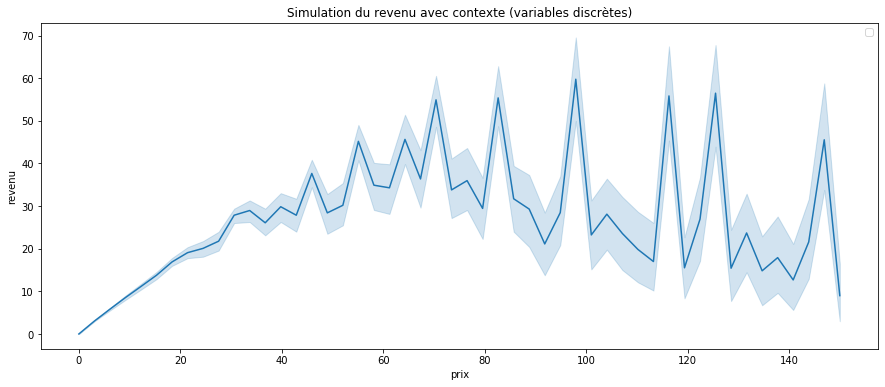

In [10]:
plot_demand_context(demand_simulation_discret,context_generator_discret)
plt.title('Simulation du revenu avec contexte (variables discrètes)')
plt.xlabel('prix')
plt.ylabel('revenu')
plt.savefig('demand_context_disc.png')

In [11]:
beta_c=np.array([0.5,-0.2,0.2])
mu_c=np.array([20,1,10])
sigma_c=np.array([20,4,2])
beta_d=np.array([[1]])
n=np.array([1])
mu_e=70
sigma_e=30
#instantiate context simulation
context_generator_cont = ContextGenerator(mu_c,sigma_c,n)

#instantiate demand simulation
demand_simulation_cont = ContextualDemandSimulation(beta_c, beta_d, mu_e, sigma_e)

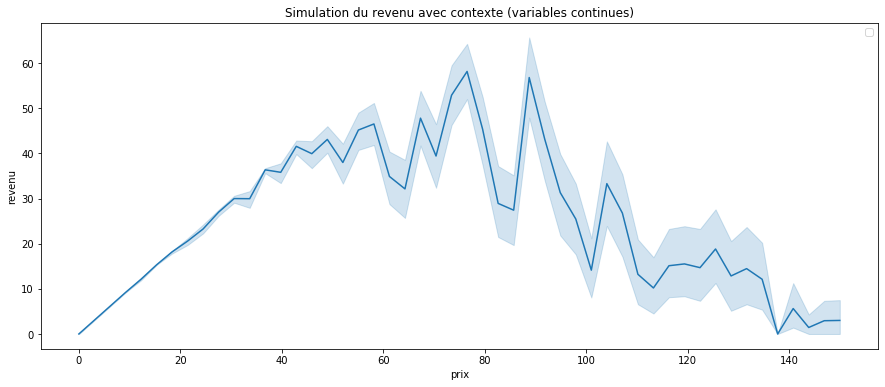

In [12]:
plot_demand_context(demand_simulation_cont,context_generator_cont)
plt.title('Simulation du revenu avec contexte (variables continues)')
plt.xlabel('prix')
plt.ylabel('revenu')
plt.savefig('demand_context_cont.png')

In [13]:
beta_c=np.array([0.2,-0.5,0.2])
mu_c=np.array([3,4,30])
sigma_c=np.array([1,4,20])
beta_d=np.array([[1,-1,7],[2,-1,20,-40]])
n=np.array([3,4])
mu_e=30
sigma_e=30
#instantiate context simulation
context_generator_all = ContextGenerator(mu_c,sigma_c,n)

#instantiate demand simulation
demand_simulation_all = ContextualDemandSimulation(beta_c, beta_d, mu_e, sigma_e)

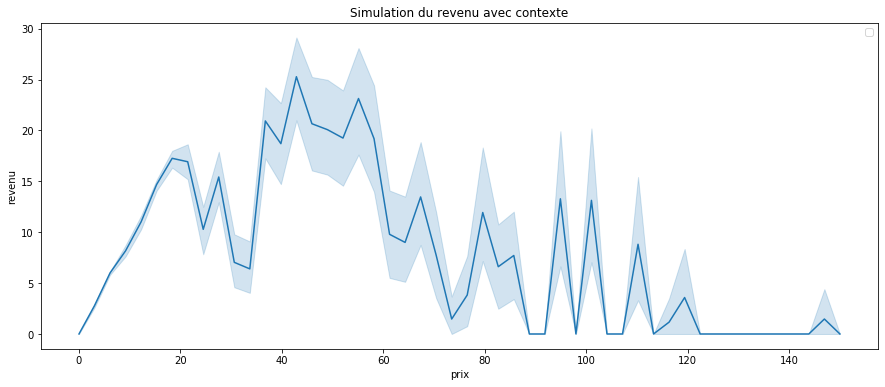

In [14]:
plot_demand_context(demand_simulation_all,context_generator_all)
plt.title('Simulation du revenu avec contexte')
plt.xlabel('prix')
plt.ylabel('revenu')
plt.savefig('demand_context_all.png')

In [15]:
#test des algorithmes thompson sampling

In [16]:
size = 10
k_p = np.linspace(5,160,size)

In [17]:
#instantiate for contextual bandit TS
norm_mean = 0
norm_std = 1

In [18]:
context_disc_1=test_contextualbandit_context(demand_simulation_discret,context_generator_discret,8,norm_mean,norm_std,0,10000)

ContextBandit model instanciated with 10 arms.


C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing\src\context_bandit.py:86: RuntimeWarning: overflow encountered in multiply
  exp_r = self.k_p*(1+np.exp(-np.dot(w,context.T)))
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: inva

C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing\src\context_bandit.py:86: RuntimeWarning: overflow encountered in multiply
  exp_r = self.k_p*(1+np.exp(-np.dot(w,context.T)))
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: inva

In [19]:
context_disc_2=test_contextualbandit_context(demand_simulation_discret,context_generator_discret,8,norm_mean,norm_std,100,10000)

ContextBandit model instanciated with 10 arms.


C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing\src\context_bandit.py:86: RuntimeWarni

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

In [20]:
context_cont_1=test_contextualbandit_context(demand_simulation_cont,context_generator_cont ,5,norm_mean,norm_std,0,10000)
context_cont_2=test_contextualbandit_context(demand_simulation_cont,context_generator_cont,5,norm_mean,norm_std,100,10000)

ContextBandit model instanciated with 10 arms.


C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

ContextBandit model instanciated with 10 arms.


C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing\src\context_bandit.py:86: RuntimeWarning: overflow encountered in multiply
  exp_r = self.k_p*(1+np.exp(-np.dot(w,context.T)))
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: inva

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing\src\context_bandit.py:86: RuntimeWarning: overflow encountered in multiply
  exp_r = self.k_p*(1+np.exp(-np.dot(w,context.T)))
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: inva

C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing\src\context_bandit.py:86: RuntimeWarning: overflow encountered in multiply
  exp_r = self.k_p*(1+np.exp(-np.dot(w,context.T)))
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: inva

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing\src\context_bandit.py:86: RuntimeWarning: overflow encountered in multiply
  exp_r = self.k_p*(1+np.exp(-np.dot(w,context.T)))
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: inva

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

In [21]:
context_all_1=test_contextualbandit_context(demand_simulation_all,context_generator_all ,11,norm_mean,norm_std,0,10000)
context_all_2=test_contextualbandit_context(demand_simulation_all,context_generator_all,11,norm_mean,norm_std,100,10000)

ContextBandit model instanciated with 10 arms.


C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing\src\context_bandit.py:86: RuntimeWarning: overflow encountered in multiply
  exp_r = self.k_p*(1+np.exp(-np.dot(w,context.T)))
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: inva

ContextBandit model instanciated with 10 arms.


C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\clementine.rosier\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\optimize.py:670: RuntimeWa

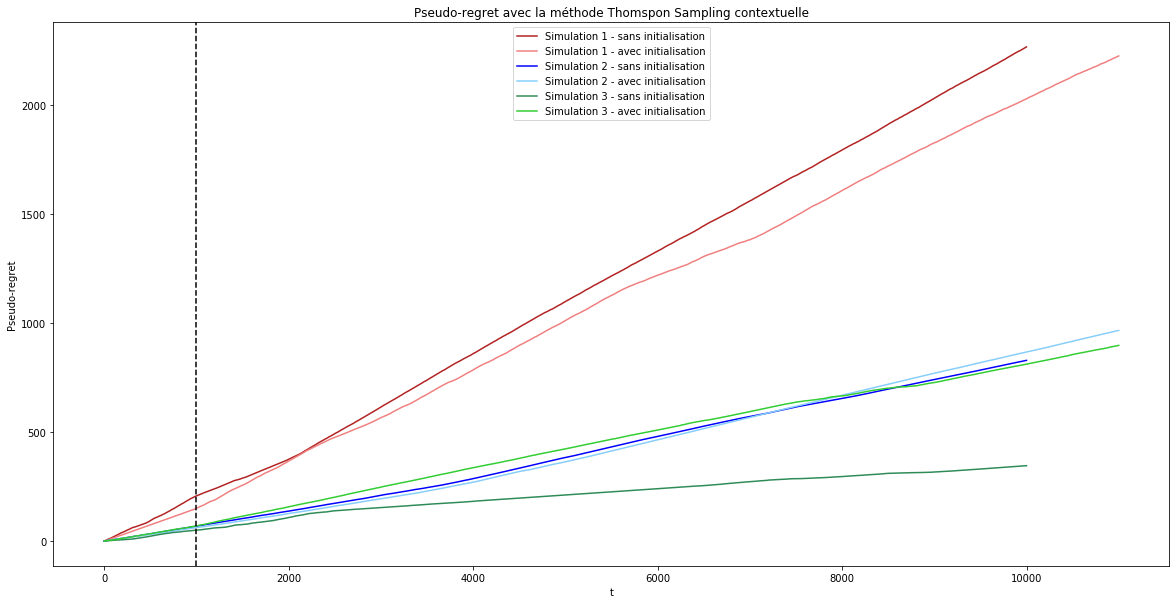

In [22]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(context_cont_1[1],c='firebrick')
#plt.plot(context_cont_2[1],c='lightcoral')
plt.plot(context_disc_1[1],c='blue')
#plt.plot(context_disc_2[1],c='lightskyblue')
plt.plot(context_all_1[1],c='seagreen')
#plt.plot(context_all_2[1],c='limegreen')
plt.title('Pseudo-regret avec la méthode Thomspon Sampling contextuelle')
plt.ylabel('Pseudo-regret')
plt.xlabel('t')
plt.axvline(x=1000,c='black',linestyle='dashed')
plt.legend(("Simulation 1 - sans initialisation","Simulation 2 - sans initialisation","Simulation 3 - sans initialisation"))
plt.savefig('thompson_context.png')

In [23]:
alpha_0 = np.repeat(1,size)
beta_0 = np.repeat(1,size)

In [26]:
simple_disc_1=test_simplebandit_context(demand_simulation_discret,context_generator_discret,k_p,alpha_0,beta_0,0,10000)
simple_disc_2=test_simplebandit_context(demand_simulation_discret,context_generator_discret,k_p,alpha_0,beta_0,100,10000)

BinomialBandit model instanciated with 10 arms.
BinomialBandit model instanciated with 10 arms.


In [27]:
simple_cont_1=test_simplebandit_context(demand_simulation_cont,context_generator_cont,k_p,alpha_0,beta_0,0,10000)
simple_cont_2=test_simplebandit_context(demand_simulation_cont,context_generator_cont,k_p,alpha_0,beta_0,100,10000)

BinomialBandit model instanciated with 10 arms.
BinomialBandit model instanciated with 10 arms.


In [28]:
simple_all_1=test_simplebandit_context(demand_simulation_all,context_generator_all,k_p,alpha_0,beta_0,0,10000)
simple_all_2=test_simplebandit_context(demand_simulation_all,context_generator_all,k_p,alpha_0,beta_0,100,10000)

BinomialBandit model instanciated with 10 arms.
BinomialBandit model instanciated with 10 arms.


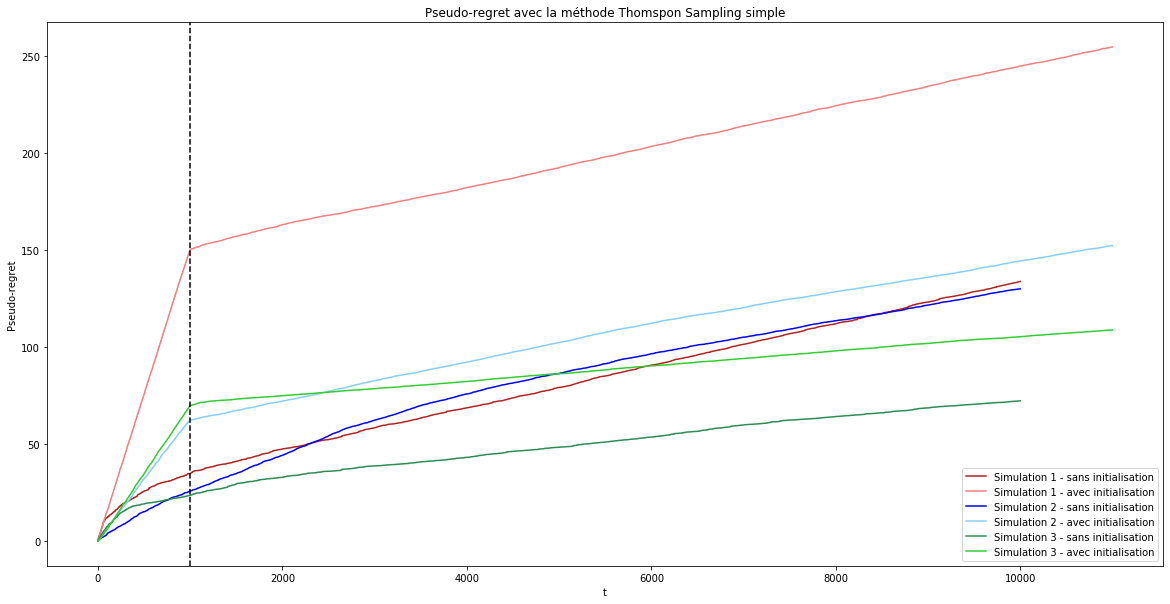

In [29]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(simple_cont_1[1],c='firebrick')
plt.plot(simple_cont_2[1],c='lightcoral')
plt.plot(simple_disc_1[1],c='blue')
plt.plot(simple_disc_2[1],c='lightskyblue')
plt.plot(simple_all_1[1],c='seagreen')
plt.plot(simple_all_2[1],c='limegreen')
plt.title('Pseudo-regret avec la méthode Thomspon Sampling simple')
plt.ylabel('Pseudo-regret')
plt.xlabel('t')
plt.axvline(x=1000,c='black',linestyle='dashed')
plt.legend(("Simulation 1 - sans initialisation","Simulation 1 - avec initialisation","Simulation 2 - sans initialisation","Simulation 2 - avec initialisation","Simulation 3 - sans initialisation","Simulation 3 - avec initialisation"))
plt.savefig('thompson_sanscontext.png')

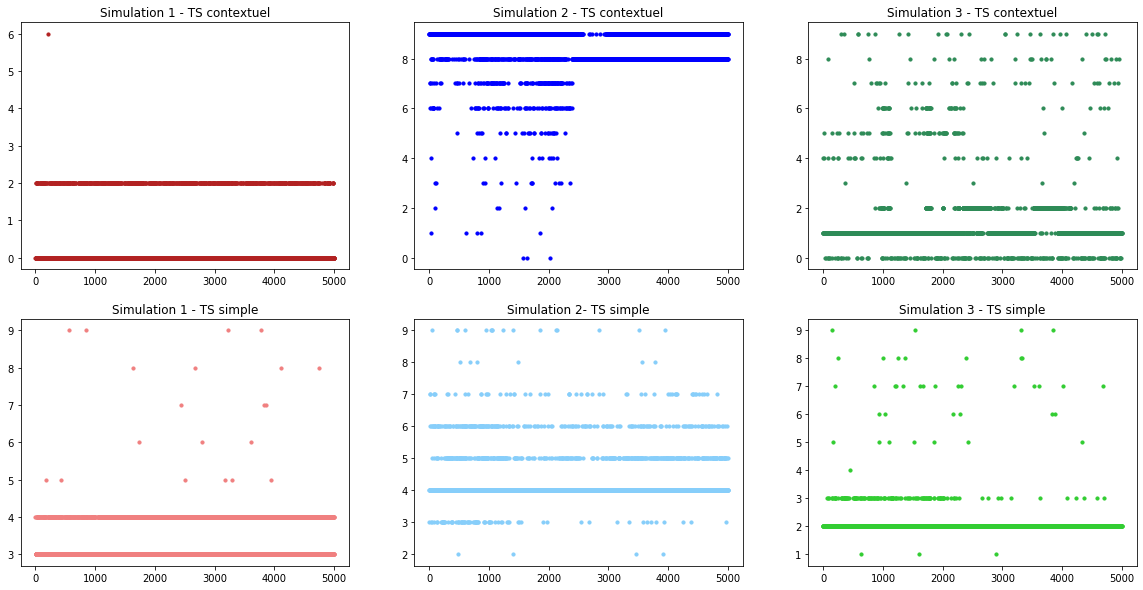

In [44]:
time=range(5000)
plt.title('Prix joués lors des 5000 derniers tirages')
plt.subplot(2,3,1)
plt.scatter(time,context_cont_1[0][5000:10000],c='firebrick',s=10)
#plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
#plt.ylim(0,121)
plt.title('Simulation 1 - TS contextuel')
plt.subplot(2,3,2)
plt.scatter(time,context_disc_1[0][5000:10000],c='blue',s=10)
#plt.axhline(y=43.3333333333333368,c='black',linestyle='dashed')
#plt.ylim(0,122)
plt.title('Simulation 2 - TS contextuel')
plt.subplot(2,3,3)
plt.scatter(time,context_all_1[0][5000:10000],c='seagreen',s=10)
#plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
#plt.ylim(0,122)
plt.title('Simulation 3 - TS contextuel')
plt.subplot(2,3,4)
plt.scatter(time,simple_cont_1[0][5000:10000],c='lightcoral',s=10)
#plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
#plt.ylim(0,122)
plt.title('Simulation 1 - TS simple')
plt.subplot(2,3,5)
plt.scatter(time,simple_disc_1[0][5000:10000],c='lightskyblue',s=10)
#plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
#plt.ylim(0,122)
plt.title('Simulation 2- TS simple')
plt.subplot(2,3,6)
plt.scatter(time,simple_all_1[0][5000:10000],c='limegreen',s=10)
#plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
#plt.ylim(0,122)
plt.title('Simulation 3 - TS simple')
plt.savefig('prix_th_context.png')

In [40]:
greedy_disc_1=test_greedybandit_context(demand_simulation_discret,context_generator_discret,k_p,0,10000)
greedy_cont_1=test_greedybandit_context(demand_simulation_cont,context_generator_cont,k_p,0,10000)
greedy_all_1=test_greedybandit_context(demand_simulation_all,context_generator_all,k_p,0,10000)


BinomialBandit model for espilon-greedy instanciated with 10 arms.
BinomialBandit model for espilon-greedy instanciated with 10 arms.
BinomialBandit model for espilon-greedy instanciated with 10 arms.


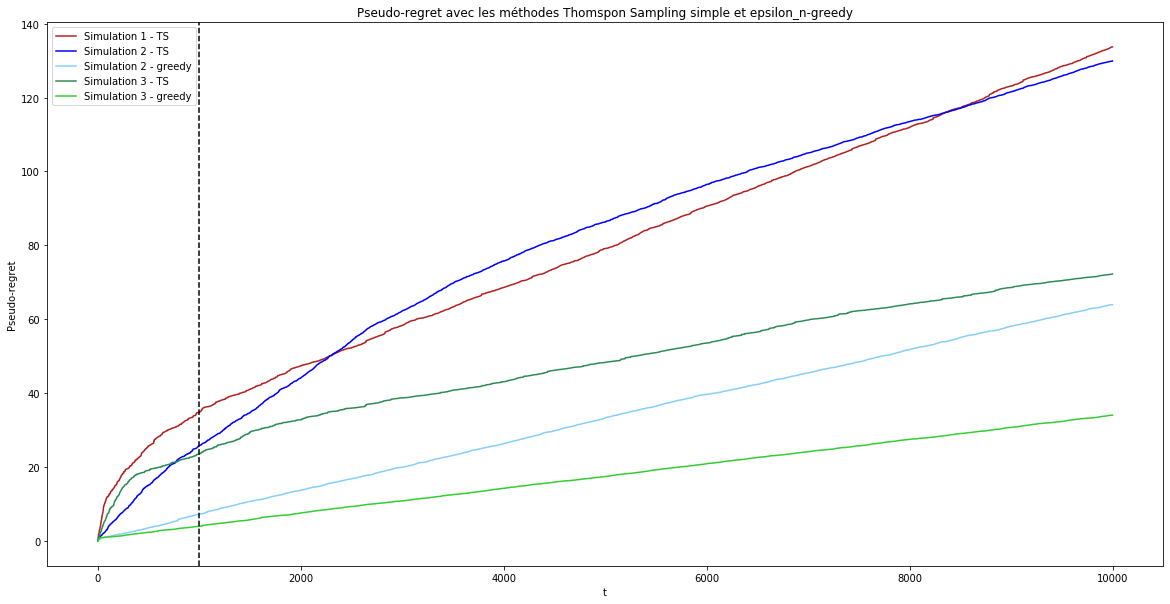

In [42]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(simple_cont_1[1],c='firebrick')
#plt.plot(greedy_cont_1[1],c='lightcoral')
plt.plot(simple_disc_1[1],c='blue')
plt.plot(greedy_disc_1[1],c='lightskyblue')
plt.plot(simple_all_1[1],c='seagreen')
plt.plot(greedy_all_1[1],c='limegreen')
plt.title('Pseudo-regret avec les méthodes Thomspon Sampling simple et epsilon_n-greedy')
plt.ylabel('Pseudo-regret')
plt.xlabel('t')
plt.axvline(x=1000,c='black',linestyle='dashed')
plt.legend(("Simulation 1 - TS","Simulation 2 - TS","Simulation 2 - greedy","Simulation 3 - TS","Simulation 3 - greedy"))
plt.savefig('thompson_greedy_sanscontext_zoom.png')

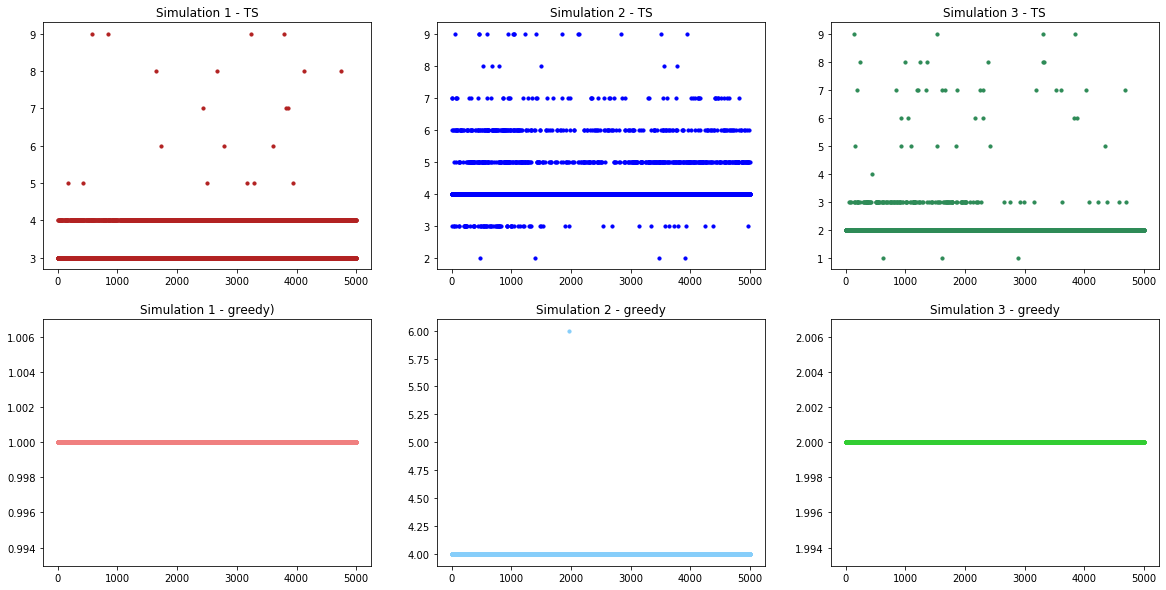

In [43]:
time=range(5000)
plt.title('Prix joués lors des 5000 derniers tirages')
plt.subplot(2,3,1)
plt.scatter(time,simple_cont_1[0][5000:10000],c='firebrick',s=10)
#plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
#plt.ylim(0,121)
plt.title('Simulation 1 - TS')
plt.subplot(2,3,2)
plt.scatter(time,simple_disc_1[0][5000:10000],c='blue',s=10)
#plt.axhline(y=43.3333333333333368,c='black',linestyle='dashed')
#plt.ylim(0,122)
plt.title('Simulation 2 - TS')
plt.subplot(2,3,3)
plt.scatter(time,simple_all_1[0][5000:10000],c='seagreen',s=10)
#plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
#plt.ylim(0,122)
plt.title('Simulation 3 - TS')
plt.subplot(2,3,4)
plt.scatter(time,greedy_cont_1[0][5000:10000],c='lightcoral',s=10)
#plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
#plt.ylim(0,122)
plt.title('Simulation 1 - greedy)')
plt.subplot(2,3,5)
plt.scatter(time,greedy_disc_1[0][5000:10000],c='lightskyblue',s=10)
#plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
#plt.ylim(0,122)
plt.title('Simulation 2 - greedy')
plt.subplot(2,3,6)
plt.scatter(time,greedy_all_1[0][5000:10000],c='limegreen',s=10)
#plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
#plt.ylim(0,122)
plt.title('Simulation 3 - greedy')
plt.savefig('prix_thgreedy_context.png')